<a href="https://colab.research.google.com/github/GyuhoonK/NLP-NSMC/blob/master/KoBERT_usingTPU_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Drive Mount

In [1]:
from google.colab import auth 
auth.authenticate_user()
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#2. KorBERT - ETRI
ETRI에서 미리 KorBERT와 tokenizer를 다운받습니다.(http://aiopen.etri.re.kr/aidata_download.php)<br>
사용한 KoRBERT 모델은 pytorch 버전, 형태소 기반의 [한국어 BERT]한국어 BERT 언어모델[1/4]입니다.

In [2]:
!pip install --quiet transformers

In [3]:
import tensorflow as tf
print("tf version : {}".format(tf.__version__))
import tensorflow_hub as hub
import json
from transformers import BertConfig
from transformers import BertModel
from transformers import TFBertModel
import datetime, os

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

import urllib3
import json
import pickle

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/NLP/src_tokenizer') # path to tokenization_mopr.py

from tokenization_morp import *

nlp_path = '/content/drive/My Drive/Colab Notebooks/NLP/' 
ckpt_path = '/content/drive/My Drive/Colab Notebooks/NLP/pytorch_model.bin'

tf version : 2.2.0


In [4]:
## from scr_tokenizer(ETRI) ##
tokenizer = FullTokenizer(nlp_path + 'vocab.korean_morp.list')

In [5]:
##load ETRIKorBERT config ###
with open(nlp_path + '/bert_config.json', 'r') as f:
  json_config = json.load(f)
f.close()
bertconfig = BertConfig(**json_config)

#3. Pipeline

NSMD dataset을 다운로드 받고 전처리를 시작합니다<br>

In [ ]:
### ncms data load###
!git clone https://github.com/e9t/nsmc.git
train_path = 'nsmc/ratings_train.txt'
test_path = 'nsmc/ratings_test.txt'

train = pd.read_csv(train_path, sep = '\t')
test =pd.read_csv(test_path, sep ='\t')

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 18.68 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [ ]:
train['document'] = train['document'].astype(str)
test['document'] = test['document'].astype(str)

print(train.shape)
print(test.shape)

(150000, 3)
(50000, 3)


get_morp 함수를 이용해 ETRI 형태소 분석 API의 문장 분석 결과를 얻습니다

In [ ]:
def get_morp(df, Key):
  '''
  ETRI 형태소분석 API를 통해 세종 품사 태그에 따른 형태소 분석을 진행합니다
  *ETRI API 사용 예제 코드 참고
  '''
  openApiURL = "http://aiopen.etri.re.kr:8000/WiseNLU"
  accessKey = Key
  analysisCode = "morp"

  http = urllib3.PoolManager()
  
  output = []
  for i in tqdm_notebook(range(0, len(df['document'].values), 200)):
    query = " γ ".join(df.document.values[i:i+200]) #문장 구분을 위한 기호 사용
    requestJson = {
      "access_key": accessKey,
      "argument": {
          "text": query,
          "analysis_code": analysisCode}}

    http = urllib3.PoolManager()
    response = http.request(
        "POST",
        openApiURL,
        headers={"Content-Type": "application/json; charset=UTF-8"},
        body=json.dumps(requestJson))
    
    res = json.loads(response.data)
  
    sentence = []
    for st in res['return_object']['sentence']:
      for word in st['morp']:
        if word['lemma'].find('γ') != -1: # 문장 구분 기호를 발견 시
          output.append(sentence) #해당 setnence는 끝난다
          sentence = []
          continue #다음 word로 진행한다
        text = "{}/{}_".format(word['lemma'],word['type'])
        sentence.append(text)
    output.append(sentence)
    
  return output

형태소 분석 결과를 바탕으로 ETRI에서 배포한 tokenzer와 vocab_list를 이용해 ids를 반환받습니다

In [ ]:
def get_input(token, max_seq = MAX_SEQ):
  '''
  형태소분석 결과를 바탕으로 BERT input을 반환합니다.
  sigle sentence를 가정함.
  '''
  while True:
    if len(token)<= max_seq - 2:
      break
    token.pop()
  token = ["[CLS]"] + token + ["[SEP]"]
  input_ids = tokenizer.convert_tokens_to_ids(token)
  
  
  input_segments = [0] * len(input_ids) # single sentence
  input_masks = [1] * len(input_ids)

  padding = [0] * (max_seq - len(input_ids))
  
  input_ids += padding
  input_masks += padding
  input_segments += padding
  
  return np.array(input_ids), np.array(input_masks), np.array(input_segments)

id를 바탕으로 mask, segment token을 추가합니다

In [ ]:
def get_dataset(tokens, label, max_seq):
  '''
  BERT input을 위한 dataset으로 반환합니다.
  '''
  input_ids = []
  input_masks = []
  input_segments = []
  labels = []
  for token in tqdm_notebook(tokens):
    id_, mask, segment = get_input(token, max_seq)
    input_ids.append(id_)
    input_masks.append(mask)
    input_segments.append(segment)
  
  input_ids = np.array(input_ids)
  input_masks = np.array(input_masks)
  input_segments = np.array(input_segments)

  label = label.values.reshape(-1,1,1)

  return (input_ids, input_masks, input_segments), label

위에서 정의한 함수들을 이용해 nsmc dataset의 전처리를 시작합니다

In [ ]:
accessKey = "Your Access KEY issued by ETRI" # API KEY, issued by ETRI #
train_morp = get_morp(train, accessKey)
test_morp = get_morp(test, accessKey)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


MAX_LEN 설정을 위해 각 문장 형태소 분석 결과의 길이를 확인합니다.<br>
최대 길이가 140이었고, 평균 19였습니다.

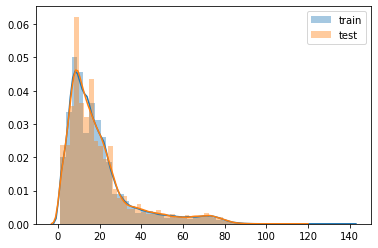

train mean length : 19.353133333333332
train maximum length : 140
test mean length : 19.4261
test maximum length : 116


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

seq_list = [list(map(len, train_morp)), list(map(len, test_morp))]

sns.distplot(seq_list[0], label = 'train')
sns.distplot(seq_list[1], label = 'test')

plt.legend()
plt.show()

for label, seq in zip(['train','test'],seq_list):
  print("{} mean length : {}".format(label, np.mean(seq)))
  print("{} maximum length : {}".format(label, np.max(seq)))

KorBERT input sequence의 max length를 셋팅합니다.

In [7]:
###token max length###
MAX_SEQ = 128

위에서 정의한 함수들을 이용하여 KorBERT를 위한 데이터셋을 만듭니다

In [ ]:
train_x, train_y = get_dataset(train_morp, train['label'], MAX_SEQ)
test_x, test_y = get_dataset(test_morp, test['label'], MAX_SEQ)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


train/val set으로 분리합니다.<br>
negative-positive 비율을 유지하여 분리했습니다(stratify).

In [35]:
from sklearn.model_selection import train_test_split 

ids_train, masks_train, segments_train = train_x
ids_test, masks_test, segments_test = test_x

### concatenate train, test.  # of original testset is 50k, which is too many for val set###
ids = np.concatenate([ids_train, ids_test], axis = 0)
masks = np.concatenate([masks_train, masks_test], axis = 0)
segments = np.concatenate([segments_train, segments_test])
labels = np.concatenate([train_y, test_y], axis = 0).reshape(-1, 1)


X_train = []
X_val = []

for X in [ids, masks, segments]:
  x_train, x_val, y_train, y_val = train_test_split(X, labels, test_size = 0.05 , # 5%(10k) used val set
                                                     random_state = 43, 
                                                    shuffle = True, # Shuffle all the dataset
                                                    stratify = labels) # Keep the ratio
  X_train.append(x_train)
  X_val.append(x_val)
###No test dataset. model will be tested using ko_data.csv###

In [36]:
### check the shape of dataset ###
print("inputs shape :")
for x in X_train + X_val:
  print(x.shape)
print("-" * 100)
print("outputs shape :")
y_train = y_train.reshape(-1, 1, 1)
y_val = y_val.reshape(-1, 1, 1)
for y in [y_train, y_val]:
  
  print(y.shape)

inputs shape :
(190000, 128)
(190000, 128)
(190000, 128)
(10000, 128)
(10000, 128)
(10000, 128)
----------------------------------------------------------------------------------------------------
outputs shape :
(190000, 1, 1)
(10000, 1, 1)


#4. Model Architecture
hyperparameter를 설정하고, 모델을 만듭니다<br>

In [ ]:
  BATCH_SIZE = 32
LEARNING_RATE = 2e-5
MAX_EPOCH = 5 # enough for FINE TUNING
DROP_OUT = 0.1
LAMD = 1e-4

binary classification이므로 activation function으로 sigmoid를 이용했습니다.

In [38]:
class BertClassify(tf.keras.Model):
  def __init__(self, drop_out, lamd):
    super(BertClassify, self).__init__()
    self.bert = TFBertModel.from_pretrained(ckpt_path, config = bertconfig, from_pt= True) #load parameter 
    self.dropout = tf.keras.layers.Dropout(drop_out)
    self.dense1 = tf.keras.layers.Dense(1, activation = 'sigmoid',
                                        kernel_regularizer = tf.keras.regularizers.l2(lamd))  # the task is binary classification, use sigmoid
    
  def call(self, inputs, training = False):
    outputs = self.bert(inputs[0],
                        attention_mask = inputs[1], 
                        token_type_ids = inputs[2],
                        training = training)
    sequence_output, pooled_output = outputs #TFBertModel returns (seq_output, pooled_output)

    x = self.dropout(pooled_output, training = training) #use pooled_output for classification
    
    logits = self.dense1(x, training = training)

    return logits

#5. Train<br>
TPU를 할당받고 모델 학습을 시작합니다.

In [ ]:
### TPU setting ###

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

binary classification이고 model output이 sinlge number이므로 loss 함수로 BinaryCrossentropy를 이용했습니다.

In [47]:
input_ids = tf.constant(ids_train[0])[None, :]
input_masks = tf.constant(masks_train[0])[None, :]
input_segments = tf.constant(segments_train[0])[None, :]
inputs_build = [input_ids, input_masks, input_segments] #to build model

with strategy.scope():
  model = BertClassify(DROP_OUT, LAMD)
  optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, epsilon=1e-8)
  check_build = model(inputs_build)

  model.compile(optimizer = optimizer,
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics= ['acc'])
  
print("the shape of model's output : {}".format(check_build.shape))
print("the shape of label : {}".format(y_train[0].shape))

the shape of model's output : (1, 1)
the shape of label : (1, 1)


overfitting 지점 직전까지 학습된 weight를 이용하기 위해 callback을 선언합니다

In [48]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(nlp_path + 'nsmc_korbert_binary_len128_bestloss.h5',
                                                 save_weights_only = True,
                                                 save_best_only = True,
                                                 monitor = 'val_loss',
                                                 model = 'min') #save the best model by val_loss
es_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1, restore_best_weights = False)

In [49]:
hist = model.fit(x = X_train,
                    y = y_train,
                    batch_size = BATCH_SIZE,
                    epochs = MAX_EPOCH,
                    validation_data = (X_val, y_val),
                    validation_batch_size = BATCH_SIZE,
                    callbacks = [cp_callback, es_callback])
                     
model.save_weights(nlp_path + 'nsmc_korbert_binary_len128_last.h5')

Epoch 1/5
5938/5938 [==============================] - 579s 98ms/step - loss: 0.3940 - acc: 0.8310 - val_loss: 0.3445 - val_acc: 0.8552
Epoch 2/5
5938/5938 [==============================] - 545s 92ms/step - loss: 0.3021 - acc: 0.8725 - val_loss: 0.3277 - val_acc: 0.8604
Epoch 3/5
5938/5938 [==============================] - 544s 92ms/step - loss: 0.2350 - acc: 0.9010 - val_loss: 0.3324 - val_acc: 0.8605


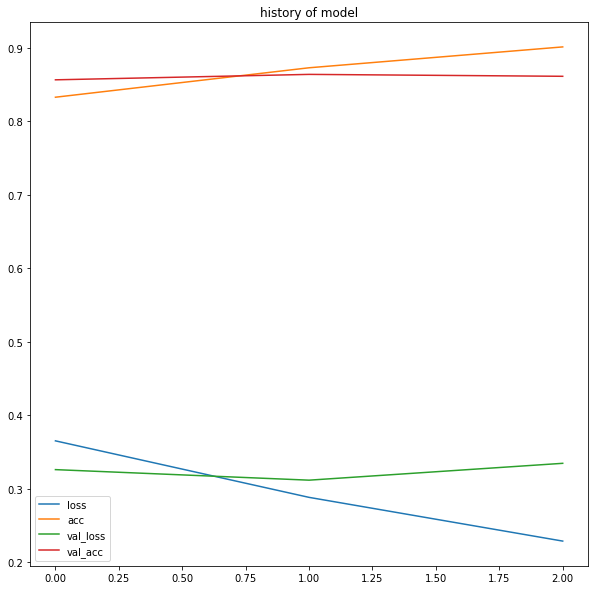

In [45]:
    ###check the learnig curves###
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))
for label in hist.history.keys():
  plt.plot(hist.history[label], label = label)
  plt.legend(loc = 'best')
  plt.title('history of model')

#6. Kaggle dataset
kaggle dataset도 ETRI API를 이용해 형태소 분석하여 token을 만들고 모델로 predict 합니다

In [50]:
###load Kaggle Daata###
ko_data = pd.read_csv(nlp_path + "ko_data.csv", encoding = 'CP949')
answer = pd.read_csv(nlp_path + "ko_sample.csv", encoding = 'CP949')

In [51]:
ko_data.rename(columns = {'Sentence' : 'document'},
               inplace = True)

In [ ]:
data_morp = get_morp(ko_data, accessKey)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


In [ ]:
test_x, _ = get_dataset(data_morp, train['label'], MAX_SEQ) #don't care train['label']. it's dummy.

val_loss가 가장 낮은 model weight를 불러와 predict하고, submit 양식에 맞게 저장합니다

In [53]:
model.load_weights(nlp_path + 'nsmc_korbert_binary_len128_last.h5')
pred = model.predict(test_x)
pred[pred >= 0.5] = 1
pred[pred < 0.5 ] = 0
answer = pd.read_csv(nlp_path + 'ko_sample.csv', index_col = 'Id')
answer['Predicted'] = pd.Series(pred.reshape(-1, ))
answer['Predicted'] = answer['Predicted'].astype(int)
answer.to_csv(nlp_path + "submit_nsmc_bestloss{}.csv".format(datetime.datetime.now().strftime('%Y%m%d%H%M%S')), index = 'Id')